## On plot les results 

In [1]:
from plot_results import  plot_loss_decompose, plot_points, plot_loss
from model import PINNs
from utils import charge_data
import json
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import numpy as np
from model import pde


In [2]:
folder_name = "8_seemed_working_with_ya0"
epoch = "epoch340"

In [3]:
param_adim = {"V": 1.0, "L": 0.025, "rho": 1.2}

In [4]:
with open("results/" + folder_name + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)
model = PINNs(hyper_param)
checkpoint = torch.load(
    "results/" + folder_name + "/" + epoch + "/" + "model_weights.pth",
    map_location=torch.device("cpu"),
)
model.load_state_dict(checkpoint["model_state_dict"])
X_train, U_train, X_full, U_full, X_border, X_border_test, mean_std, X_pde, X_test_pde, X_test_data, U_test_data = charge_data(
    hyper_param, param_adim
)

/tmp/ipykernel_12770/2119057137.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


fichier n°0 chargé
fichier n°1 chargé
fichier n°2 chargé
fichier n°3 chargé
fichier n°4 chargé
Starting X_train
Simu n°0/5
Time:14.501
Simu n°1/5
Time:109.300
Simu n°2/5
Time:152.001
Simu n°3/5
Time:181.406
Simu n°4/5
Time:205.710
X_train OK
X_border OK
X_pde OK


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def plot_flow(
    x,
    y,
    t,
    norme_vitesse_data,
    norme_vitesse_predict,
    name_file,
    fps=7,
    title="Norme vitesse",
):
    # Créer une figure et des axes
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Déterminer les valeurs min et max pour la colormap
    vmin = min(np.min(norme_vitesse_data), np.min(norme_vitesse_predict))
    vmax = max(np.max(norme_vitesse_data), np.max(norme_vitesse_predict))

    # Initialiser les cartes de chaleur
    indices = np.where(t == np.min(t))
    c1 = ax[0].tripcolor(
        x[indices],
        y[indices],
        norme_vitesse_data[indices],
        shading="gouraud",
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
    )
    c2 = ax[1].tripcolor(
        x[indices],
        y[indices],
        norme_vitesse_predict[indices],
        shading="gouraud",
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
    )

    ax[0].set_title("Données")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[1].set_title("Prédictions")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    # Ajouter une barre de couleur globale (fixée)
    cbar = fig.colorbar(c1, ax=ax, orientation="vertical", label=f"{title}")

    # Fonction d'initialisation
    def init():
        return c1, c2

    # Fonction d'animation
    def update(frame):
        print(f"Frame {frame}")
        time_sorted = sorted(set(t))
        current_time = time_sorted[frame]
        indices = np.where(t == current_time)

        # Mettre à jour les données de la première carte de chaleur
        c1.set_array(norme_vitesse_data[indices].flatten())

        # Mettre à jour les données de la deuxième carte de chaleur
        c2.set_array(norme_vitesse_predict[indices].flatten())

        # Mettre à jour le titre
        plt.suptitle(f"{title} à t={current_time:.2f}", fontsize=16)

        return c1, c2

    # Créer l'animation
    ani = FuncAnimation(
        fig, update, frames=len(set(t)), init_func=init, blit=False, repeat=True
    )

    # Sauvegarder l'animation
    ani.save(name_file, writer="pillow", fps=fps)


In [ ]:
for ya0_norm in X_full[:, 3].unique():
    masque = X_full[:, 3] == ya0_norm
    X_ = X_full[masque]
    U_ = U_full[masque]
    U_ = U_.detach().numpy()
    predict = model(X_).detach()
    x_norm_pred, y_norm_pred, t_norm_pred = (
        X_.detach().numpy()[:, 0],
        X_.detach().numpy()[:, 1],
        X_.detach().numpy()[:, 2],
    )
    u_norm_pred, v_norm_pred, p_norm_pred = (
        predict.detach().numpy()[:, 0],
        predict.detach().numpy()[:, 1],
        predict.detach().numpy()[:, 2],
    )
    x_pred = (x_norm_pred * mean_std["x_std"].item() +
              mean_std["x_mean"].item()) * param_adim["L"]
    y_pred = (y_norm_pred * mean_std["y_std"].item() +
              mean_std["y_mean"].item()) * param_adim["L"]
    t_pred = (t_norm_pred * mean_std["t_std"].item() + mean_std["t_mean"].item()) * (
        param_adim["L"] / param_adim["V"]
    )
    u_pred = (u_norm_pred * mean_std["u_std"].item() +
              mean_std["u_mean"].item()) * param_adim["V"]
    v_pred = (v_norm_pred * mean_std["v_std"].item() +
              mean_std["v_mean"].item()) * param_adim["V"]
    p_pred = (p_norm_pred * mean_std["p_std"].item() + mean_std["p_mean"].item()) * (
        (param_adim["V"] ** 2) * param_adim["rho"]
    )
    u_data = (U_[:, 0] * mean_std["u_std"].item() +
              mean_std["u_mean"].item()) * param_adim["V"]
    v_data = (U_[:, 1] * mean_std["v_std"].item() +
              mean_std["v_mean"].item()) * param_adim["V"]
    p_data = (U_[:, 2] * mean_std["p_std"].item() + mean_std["p_mean"].item()) * (
        (param_adim["V"] ** 2) * param_adim["rho"]
    )

    norme_vitesse_data = np.sqrt(u_data**2 + v_data**2)
    norme_vitesse_predict = np.sqrt(u_pred**2 + v_pred**2)
    ya0_ = (ya0_norm * mean_std["ya0_std"] + mean_std['ya0_mean']) * param_adim['L']
    os.makedirs("results/" + "/" + folder_name + "/" + f"ya0_{ya0_:.2e}", exist_ok=True)
    plot_flow(
        x_pred,
        y_pred, 
        t_pred, 
        norme_vitesse_data, 
        norme_vitesse_predict, 
        name_file= "results/" + "/" + folder_name + "/" +f"ya0_{ya0_:.2e}/"+  f"result_vitesse.gif", 
        title = f"Norme vitesse"
        )
    plot_flow(
        x_pred,
        y_pred, 
        t_pred, 
        p_data, 
        p_pred, 
        name_file= "results/" + "/" + folder_name + "/" +f"ya0_{ya0_:.2e}/"+ "result_pression.gif", 
        title = f"Pression"
        )
    masque_train = X_train[:, 3] == ya0_norm
    X_train_ = X_train[masque_train]
    masque_border = X_border[:, 3] == ya0_norm
    X_border_ = X_border[masque_border]
    plot_points(X_train_, X_border_, mean_std, param_adim, "results/" + "/" + folder_name + "/" +f"ya0_{ya0_:.2e}/"+ "points")



    

Frame 0
Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Frame 52
Frame 53
Frame 54
Frame 55
Frame 56
Frame 57
Frame 58
Frame 59
Frame 60


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

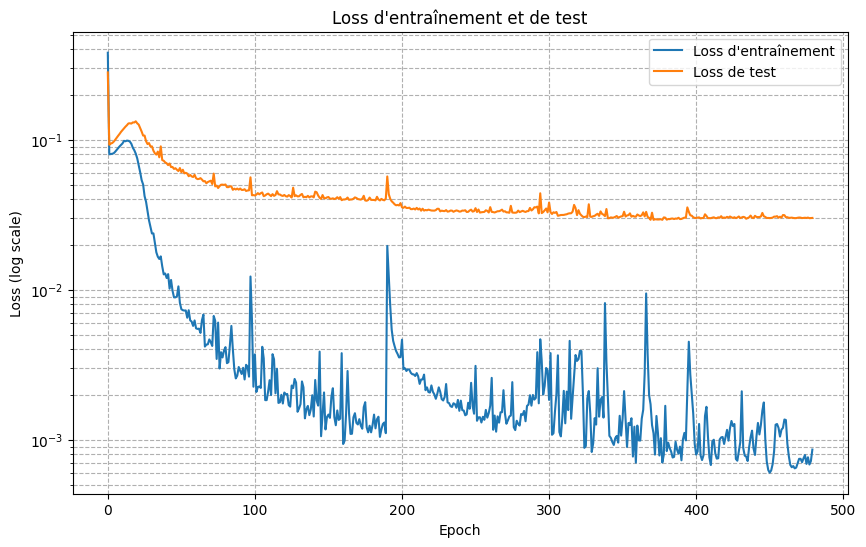

In [21]:

plot_loss_decompose('results/'+folder_name, "results/"+folder_name+ f"/epoch{epoch}", 'loss_decompose.png')
plot_loss('results/'+folder_name, "results/"+folder_name+ f"/epoch{epoch}", 'loss.png')

### On regarde sur des données pas entrainées 

In [5]:
hyper_param_2 = {
    "H": 230.67,  # la rigidité du ressort
    "ya0": [
        0.01,
        0.0175,
        0.005,
        0.0075,
    ],  # la position initiale du ressort
    "m": 1.57,  # la masse du ressort
    "file": [
        "data_john_1_case_2.csv",
        "data_john_3_case_2.csv",
        'data_john_6_case_2.csv',
        'data_john_8_case_2.csv',
    ],
    "nb_epoch": 1000,  # epoch number
    "save_rate": 20,  # rate to save
    "dynamic_weights": True,
    "lr_weights": 1e-1,  # si dynamic weights
    "weight_data": 1.0,
    "weight_pde": 1.0,
    "weight_border": 1.0,
    "batch_size": 10000,  # for the pde
    "nb_points_pde": 1000000,  # Total number of pde points
    "Re": 100,
    "lr_init": 0.001,
    "gamma_scheduler": 0.999,  # pour la lr
    "nb_layers": 25,
    "nb_neurons": 32,
    "n_pde_test": 5000,
    "n_data_test": 5000,
    "nb_points": 12*12,  # le nombre de points pris par axe par pas de temps
    "x_min": -0.1,
    "x_max": 0.1,
    "y_min": -0.06,
    "y_max": 0.06,
    "t_min": 6.5,
    "t_max": 8,
    "nb_points_close_cylinder": 50,  # le nombre de points proches du cylindre
    "nb_points_border": 25,  # le nombrede points sur la condition init
}

In [6]:
X_train_valid, U_train_valid, X_full_valid, U_full_valid, X_border_valid, X_border_test_valid, mean_std_valid, X_pde_valid, X_test_pde_valid, X_test_data_valid, U_test_data_valid = charge_data(
    hyper_param_2, param_adim
)

fichier n°0 chargé
fichier n°1 chargé
fichier n°2 chargé
fichier n°3 chargé
Starting X_train
Simu n°0/4
Time:10.178
Simu n°1/4
Time:40.278
Simu n°2/4
Time:68.879
Simu n°3/4
Time:95.677
X_train OK
X_border OK
X_pde OK


Frame 0
Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Frame 52
Frame 53
Frame 54
Frame 55
Frame 56
Frame 57
Frame 58
Frame 59
Frame 60
Frame 0
Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Fra

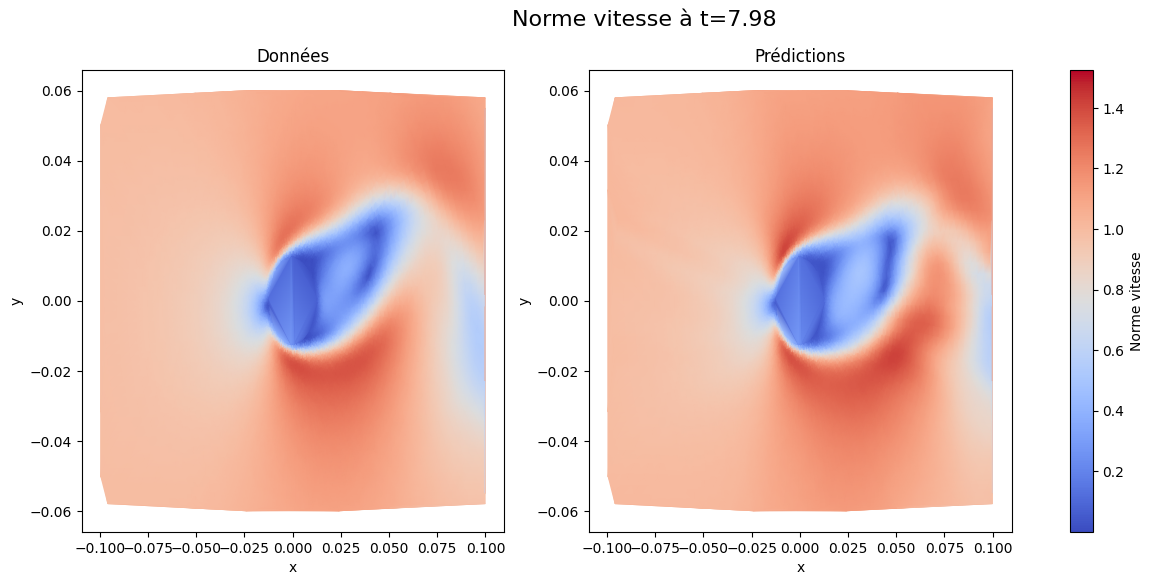

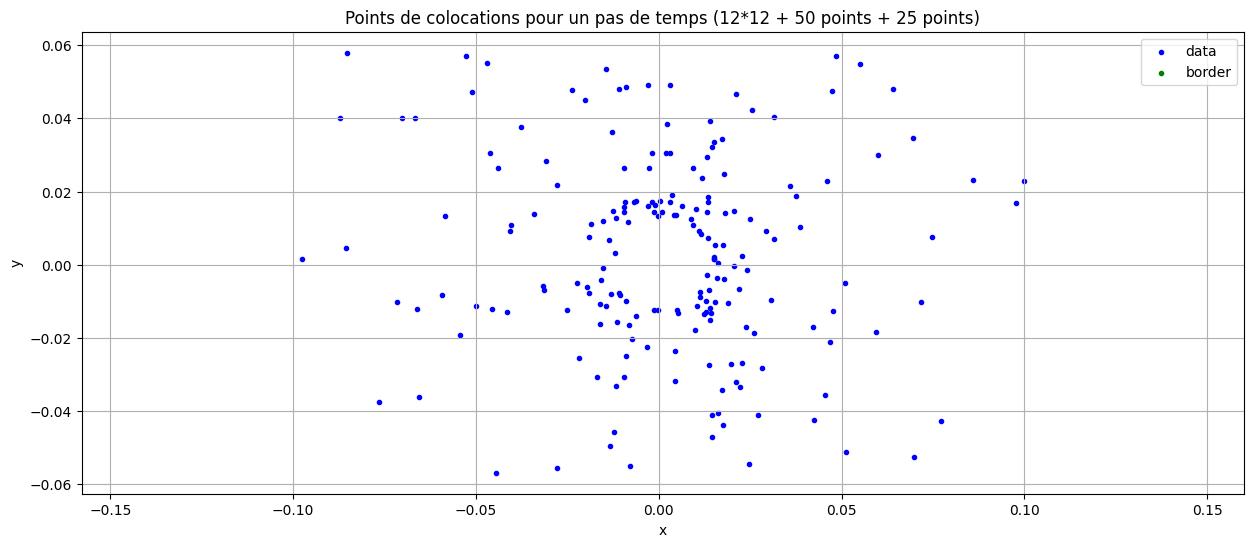

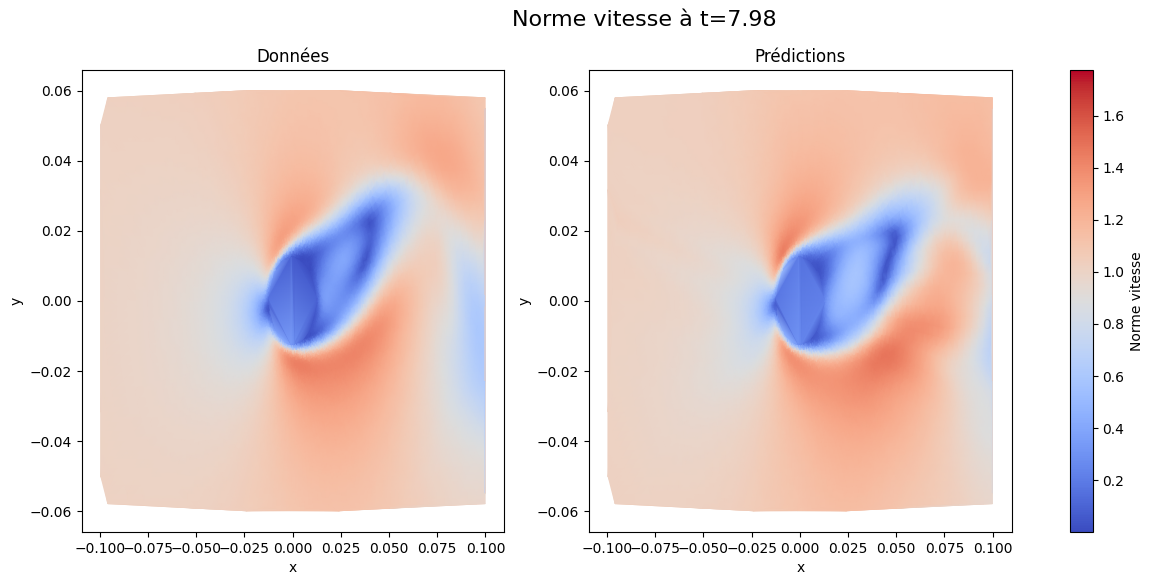

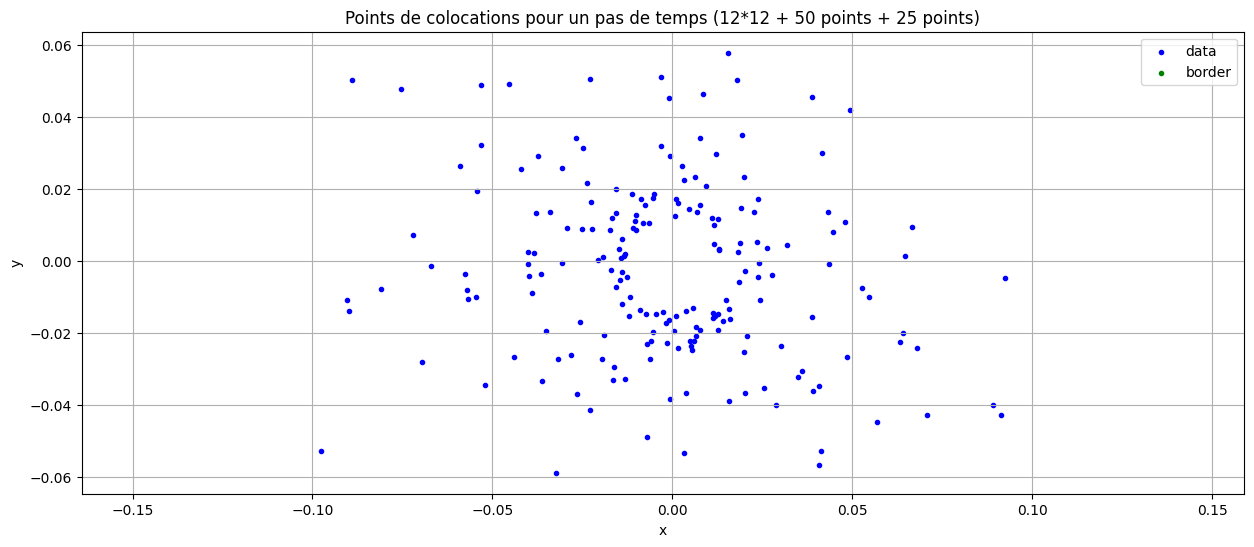

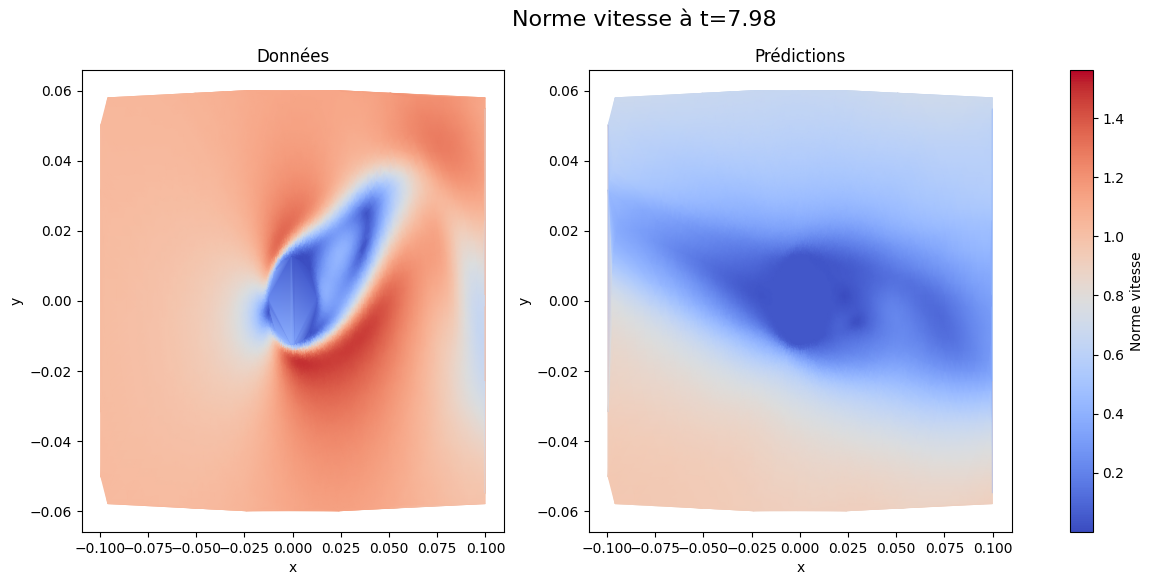

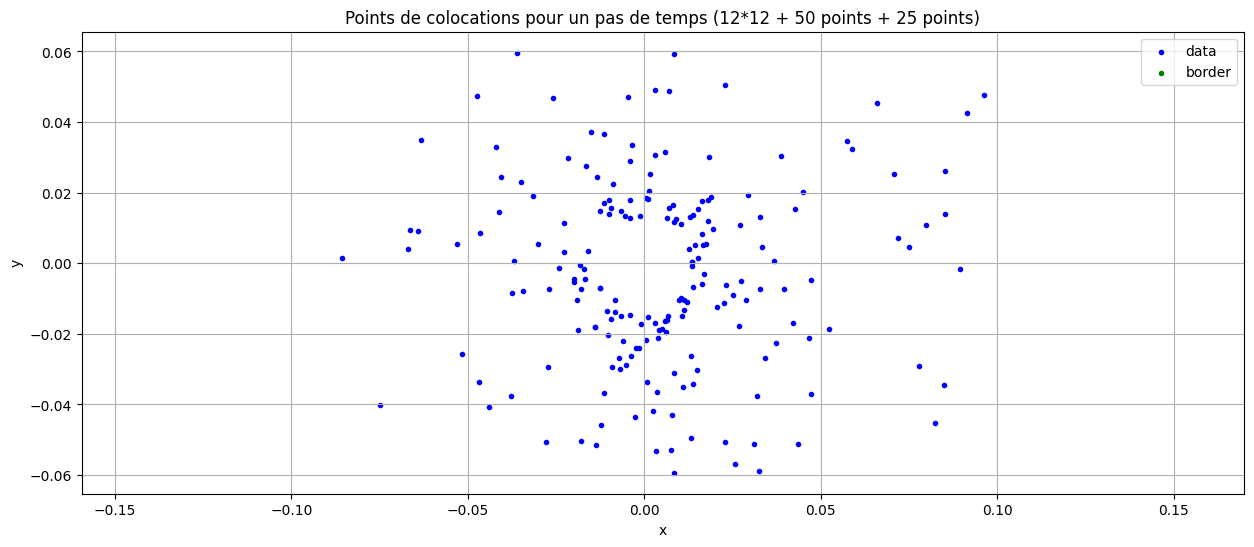

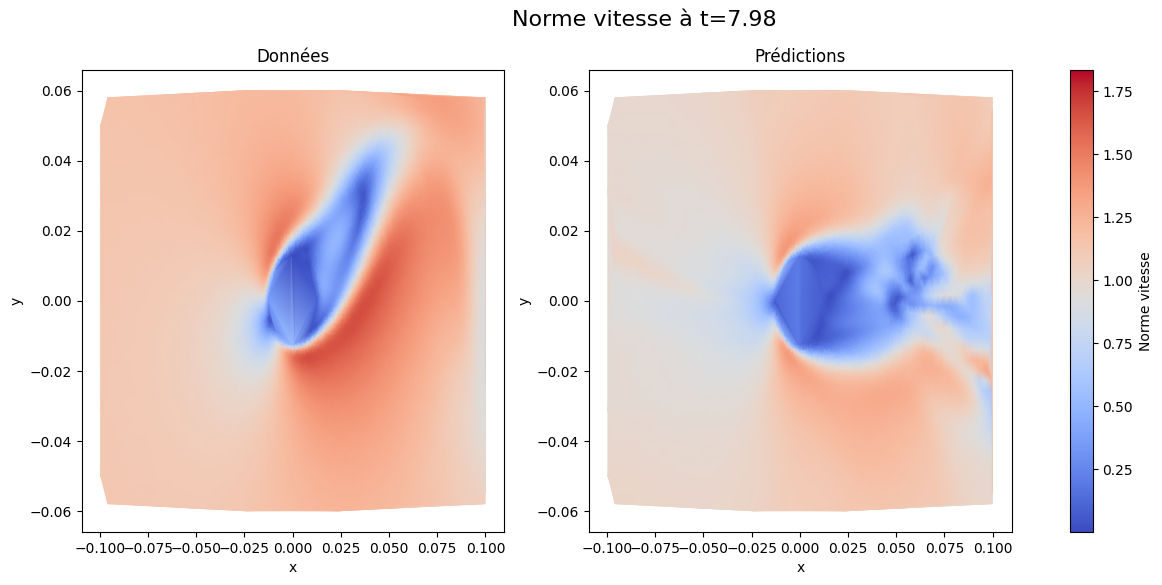

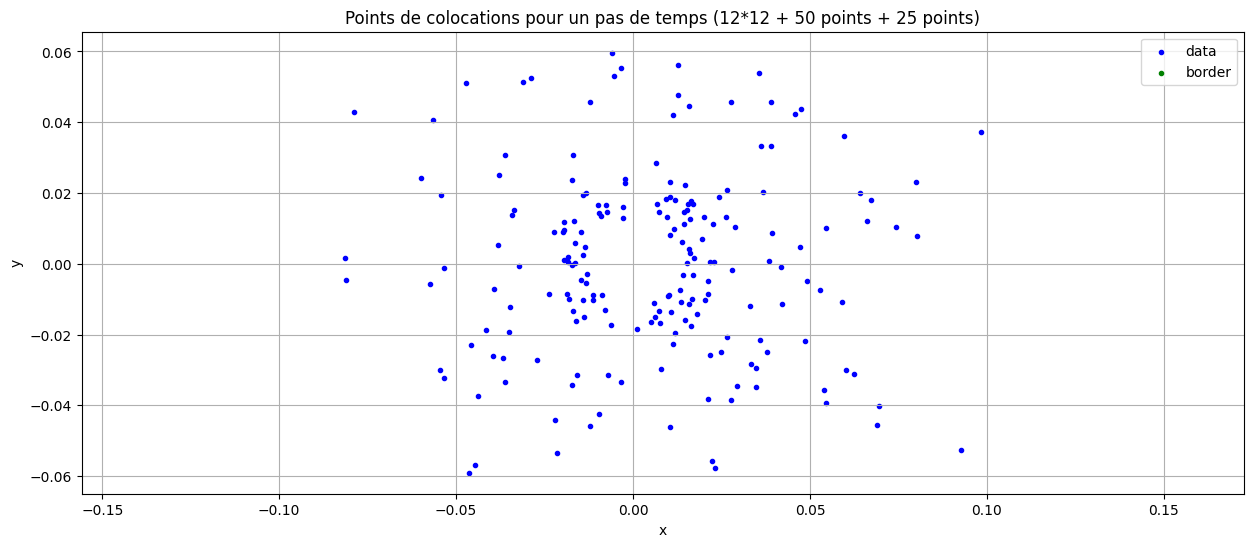

In [ ]:
for ya0_norm in X_full_valid[:, 3].unique():
    masque = X_full_valid[:, 3] == ya0_norm
    X_ = X_full_valid[masque]
    U_ = U_full_valid[masque]
    U_ = U_.detach().numpy()
    predict_valid = model(X_).detach()
    x_norm_pred, y_norm_pred, t_norm_pred = (
        X_.detach().numpy()[:, 0],
        X_.detach().numpy()[:, 1],
        X_.detach().numpy()[:, 2],
    )
    u_norm_pred, v_norm_pred, p_norm_pred = (
        predict_valid.detach().numpy()[:, 0],
        predict_valid.detach().numpy()[:, 1],
        predict_valid.detach().numpy()[:, 2],
    )
    x_pred = (x_norm_pred * mean_std["x_std"].item() +
              mean_std["x_mean"].item()) * param_adim["L"]
    y_pred = (y_norm_pred * mean_std["y_std"].item() +
              mean_std["y_mean"].item()) * param_adim["L"]
    t_pred = (t_norm_pred * mean_std["t_std"].item() + mean_std["t_mean"].item()) * (
        param_adim["L"] / param_adim["V"]
    )
    u_pred = (u_norm_pred * mean_std["u_std"].item() +
              mean_std["u_mean"].item()) * param_adim["V"]
    v_pred = (v_norm_pred * mean_std["v_std"].item() +
              mean_std["v_mean"].item()) * param_adim["V"]
    p_pred = (p_norm_pred * mean_std["p_std"].item() + mean_std["p_mean"].item()) * (
        (param_adim["V"] ** 2) * param_adim["rho"]
    )
    u_data = (U_[:, 0] * mean_std["u_std"].item() +
              mean_std["u_mean"].item()) * param_adim["V"]
    v_data = (U_[:, 1] * mean_std["v_std"].item() +
              mean_std["v_mean"].item()) * param_adim["V"]
    p_data = (U_[:, 2] * mean_std["p_std"].item() + mean_std["p_mean"].item()) * (
        (param_adim["V"] ** 2) * param_adim["rho"]
    )

    norme_vitesse_data = np.sqrt(u_data**2 + v_data**2)
    norme_vitesse_predict = np.sqrt(u_pred**2 + v_pred**2)
    ya0_ = (ya0_norm * mean_std["ya0_std"] + mean_std['ya0_mean']) * param_adim['L']
    os.makedirs("results/" + "/" + folder_name + "/" + f"valid_ya0_{ya0_:.2e}", exist_ok=True)
    plot_flow(
        x_pred,
        y_pred, 
        t_pred, 
        norme_vitesse_data, 
        norme_vitesse_predict, 
        name_file= "results/" + "/" + folder_name + "/" +f"valid_ya0_{ya0_:.2e}/"+  f"result_vitesse.gif", 
        title = f"Norme vitesse"
        )
    plot_flow(
        x_pred,
        y_pred, 
        t_pred, 
        p_data, 
        p_pred, 
        name_file= "results/" + "/" + folder_name + "/" +f"valid_ya0_{ya0_:.2e}/"+ "result_pression.gif", 
        title = f"Pression"
        )
    masque_train = X_train[:, 3] == ya0_norm
    X_train_ = X_train[masque_train]
    masque_border = X_border[:, 3] == ya0_norm
    X_border_ = X_border[masque_border]
    plot_points(X_train_, X_border_, mean_std, param_adim, "results/" + "/" + folder_name + "/" +f"valid_ya0_{ya0_:.2e}/"+ "points")



    

### On plot la loss maintenant 

In [7]:
X_border_test[:, 3].unique()

tensor([-1.1838, -0.8355, -0.1390,  0.5576,  1.6025])

In [8]:
X_test_data[:, 3].unique()

tensor([-1.1838, -0.8355, -0.1390,  0.5576,  1.6025])

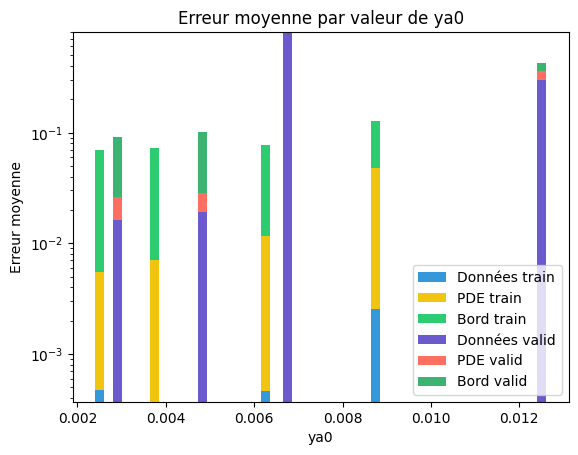

In [13]:
for k, ya0_norm in enumerate(X_test_data[:, 3].unique()):
    masque_data = X_test_data[:, 3] == ya0_norm
    masque_border = X_border_test[:, 3] == ya0_norm
    masque_pde = X_test_pde[:, 3] == ya0_norm
    predict_data = model(X_test_data[masque_data])
    predict_border = model(X_border_test[masque_border])
    loss_data = torch.mean((predict_data - U_test_data[masque_data])**2)
    goal_border = torch.tensor(
                    [
                        -mean_std["u_mean"] / mean_std["u_std"],
                        -mean_std["v_mean"] / mean_std["v_std"],
                    ],
                    dtype=torch.float32,
                ).expand(predict_border.shape[0], 2)
    loss_border = torch.mean((predict_border[:, :2] - goal_border)**2)  # (MSE)
    X_pde_ = X_test_pde[masque_pde].clone().requires_grad_(True)
    predict_pde = model(X_pde_)
    pred_pde1, pred_pde2, pred_pde3 = pde(
        predict_pde,
        X_pde_,
        Re=hyper_param['Re'],
        x_std=mean_std["x_std"],
        y_std=mean_std["y_std"],
        u_mean=mean_std["u_mean"],
        v_mean=mean_std["v_mean"],
        p_std=mean_std["p_std"],
        t_std=mean_std["t_std"],
        t_mean=mean_std["t_mean"],
        u_std=mean_std["u_std"],
        v_std=mean_std["v_std"],
        ya0_mean=mean_std["ya0_mean"],
        ya0_std=mean_std["ya0_std"],
        w_0=(hyper_param["H"] / hyper_param["m"]) ** 0.5,
        L_adim=param_adim['L'],
        V_adim=param_adim['V'],
    )
    loss_pde = (
        torch.mean(pred_pde1**2)
        + torch.mean(pred_pde2**2)
        + torch.mean(pred_pde3**2)
    )
    loss = 1/3 * (loss_data.item() + loss_pde.item() + loss_border.item())
    ya0_ = (ya0_norm * mean_std["ya0_std"] + mean_std['ya0_mean']) * param_adim['L']
    if k==0:
        plt.bar(ya0_, 1/3 *loss_data.item(), width=0.0002, color='#3498db', label='Données train')
        plt.bar(ya0_, 1/3 *loss_pde.item(), bottom=1/3 *loss_data.item(), width=0.0002, color='#f1c40f', label='PDE train')    
        plt.bar(ya0_, 1/3 *loss_border.item(), bottom=1/3 *loss_data.item()+1/3 *loss_pde.item(), width=0.0002, color='#2ecc71', label='Bord train')
    else:
        plt.bar(ya0_, 1/3 *loss_data.item(), width=0.0002, color='#3498db')
        plt.bar(ya0_, 1/3 *loss_pde.item(), bottom=1/3 *loss_data.item(), width=0.0002, color='#f1c40f')    
        plt.bar(ya0_, 1/3 *loss_border.item(), bottom=1/3 *loss_data.item()+1/3 *loss_pde.item(), width=0.0002, color='#2ecc71')


for k, ya0_norm in enumerate(X_test_data_valid[:, 3].unique()):
    masque_data = X_test_data_valid[:, 3] == ya0_norm
    masque_border = X_border_test_valid[:, 3] == ya0_norm
    masque_pde = X_test_pde_valid[:, 3] == ya0_norm
    predict_data = model(X_test_data_valid[masque_data])
    predict_border = model(X_border_test_valid[masque_border])
    loss_data = torch.mean((predict_data - U_test_data_valid[masque_data])**2)
    goal_border = torch.tensor(
                    [
                        -mean_std["u_mean"] / mean_std["u_std"],
                        -mean_std["v_mean"] / mean_std["v_std"],
                    ],
                    dtype=torch.float32,
                ).expand(predict_border.shape[0], 2)
    loss_border = torch.mean((predict_border[:, :2] - goal_border)**2)  # (MSE)
    X_pde_ = X_test_pde_valid[masque_pde].clone().requires_grad_(True)
    predict_pde = model(X_pde_)
    pred_pde1, pred_pde2, pred_pde3 = pde(
        predict_pde,
        X_pde_,
        Re=hyper_param['Re'],
        x_std=mean_std["x_std"],
        y_std=mean_std["y_std"],
        u_mean=mean_std["u_mean"],
        v_mean=mean_std["v_mean"],
        p_std=mean_std["p_std"],
        t_std=mean_std["t_std"],
        t_mean=mean_std["t_mean"],
        u_std=mean_std["u_std"],
        v_std=mean_std["v_std"],
        ya0_mean=mean_std["ya0_mean"],
        ya0_std=mean_std["ya0_std"],
        w_0=(hyper_param["H"] / hyper_param["m"]) ** 0.5,
        L_adim=param_adim['L'],
        V_adim=param_adim['V'],
    )
    loss_pde = (
        torch.mean(pred_pde1**2)
        + torch.mean(pred_pde2**2)
        + torch.mean(pred_pde3**2)
    )
    loss = 1/3 * (loss_data.item() + loss_pde.item() + loss_border.item())
    ya0_ = (ya0_norm * mean_std["ya0_std"] + mean_std['ya0_mean']) * param_adim['L']
    
    if k==0:
        plt.bar(ya0_, 1/3 *loss_data.item(), width=0.0002, color='#6A5ACD', label='Données valid')
        plt.bar(ya0_, 1/3 *loss_pde.item(), bottom=1/3 *loss_data.item(), width=0.0002, color='#FF6F61', label='PDE valid')    
        plt.bar(ya0_, 1/3 *loss_border.item(), bottom=1/3 *loss_data.item()+1/3 *loss_pde.item(), width=0.0002, color='#3CB371', label='Bord valid')
    else:
        plt.bar(ya0_, 1/3 *loss_data.item(), width=0.0002, color='#6A5ACD')
        plt.bar(ya0_, 1/3 *loss_pde.item(), bottom=1/3 *loss_data.item(), width=0.0002, color='#FF6F61')    
        plt.bar(ya0_, 1/3 *loss_border.item(), bottom=1/3 *loss_data.item()+1/3 *loss_pde.item(), width=0.0002, color='#3CB371')



# Ajouter un titre et des labels
plt.title('Erreur moyenne par valeur de ya0')
plt.yscale('log')
plt.xlabel('ya0')
plt.ylabel('Erreur moyenne')
plt.legend()

In [9]:
u_test = model(X_test_data)

In [10]:
print(torch.mean((u_test - U_test_data)**2))

tensor(0.0061, grad_fn=<MeanBackward0>)


In [14]:
mean_std['ya0_std']

tensor(0.1436)

In [15]:
mean_std['ya0_mean']

tensor(0.2699)